In [882]:
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor, Normalize, Compose
from torch import device, cuda, manual_seed, nn
from torch.optim import Adam
import torch

import matplotlib.pyplot as plt
import numpy as np

In [883]:
DEVICE = device('cuda' if cuda.is_available() else 'cpu')

# Get the data

In [884]:
# Set parameters
batch_size_train = 256
batch_size_test = 1000
lr = 1e-3
epochs = 80

seed = 1
manual_seed(seed);

In [885]:
DATAPATH = 'C:/Users/matan/Documents/data'
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
train_data = MNIST(DATAPATH, train = True, download=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
print("Number of train images:", len(train_data))

test_data = MNIST(DATAPATH, train=False, download=False, transform=transform)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)
print("Number of test images:", len(test_data))

Number of train images: 60000
Number of test images: 10000


In [886]:
# Look at examples
examples = enumerate(test_loader)
batch_idx, (images, labels) = next(examples)
print(images.shape)

torch.Size([1000, 1, 28, 28])


# Make and train the model

In [887]:
dim_input = 28*28
dim_hidden = 512
dim_latent = 2
N_train = len(train_data)
print(N_train)

60000


In [888]:
class Encoder(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_latent):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, dim_hidden)
        self.mu = nn.Linear(dim_hidden, dim_latent)
        self.var = nn.Linear(dim_hidden, dim_latent)

        self.activation = nn.LeakyReLU(0.2) #nn.Tanh()
    
    def forward(self, x):
        h1 = self.activation(self.fc1(x))
        h1 = self.activation(self.fc2(h1))
        return self.mu(h1), self.var(h1)


class Decoder(nn.Module):
    def __init__(self, dim_latent, dim_hidden, dim_input):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(dim_latent, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, dim_hidden)
        self.fc3 = nn.Linear(dim_hidden, dim_input)
        self.activation = nn.LeakyReLU(0.2) #nn.Tanh()

    def forward(self, z):
        h1 = self.activation(self.fc1(z))
        h1 = self.activation(self.fc2(h1))
        #return self.mu(h1), self.var(h1)
        #return torch.tanh(self.fc3(h1))
        return torch.sigmoid(self.fc3(h1))


class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparametrization(self, mean, var):
        """ Reparametrization trick. Samples z values. """
        eps = torch.randn_like(var).to(DEVICE) # Ransom tensor in same shape as var
        z = mean + var*eps
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        std = torch.exp(0.5 * log_var)
        z = self.reparametrization(mean, std)
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

    def get_latents(self, x):
        """ Encode data x into latent representations z. """
        mean, log_var = self.Encoder(x)
        std = torch.exp(0.5 * log_var)
        z = self.reparametrization(mean, std)
        return z


def loss_function(x, out, mean, log_var, beta = 1):
    """ Loss function for the model. """
    x_hat=out
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    #reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KL_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    #reproduction_loss = reproduction_loss * (1 - beta)
    KL_divergence = KL_divergence * beta
    #print("Loss:", reproduction_loss, KL_divergence)
    return reproduction_loss + KL_divergence, reproduction_loss, KL_divergence

In [889]:
encoder = Encoder(dim_input, dim_hidden, dim_latent).to(DEVICE)
decoder = Decoder(dim_latent, dim_hidden, dim_input).to(DEVICE)
model = Model(encoder, decoder).to(DEVICE)
optimizer = Adam(model.parameters(), lr=lr)
print(DEVICE)

cuda


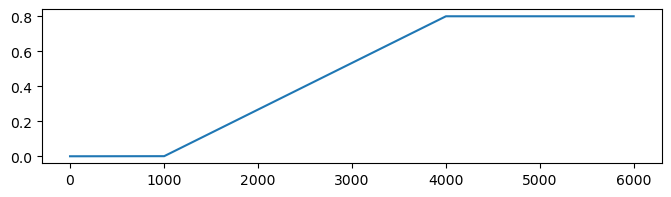

In [928]:
def beta_func(step):
    start = 1000
    stop = 4000
    scale = 0.8 #(28*28)
    if step < start:
        return 0
    elif step > stop:
        return scale
    else: 
        return scale * (step - start)/(stop - start)

test = np.linspace(0, 6000, 5000)
plt.figure(figsize=(8,2))
plt.plot(test, [beta_func(s) for s in test])

In [891]:
# Start training
model.train()

train_losses = []
train_r_losses = []
train_kl_losses = []
beta_vals = []
step = 0
for epoch in range(epochs):
    loss_this_epoch = 0
    r_loss_this_epoch = 0
    kl_loss_this_epoch = 0
    for batch, (x, _) in enumerate(train_loader):
        batch_size = x.shape[0]
        x = x.view(batch_size, dim_input)   # Flatten
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, logvar = model(x)
        beta = beta_func(step)
        loss, r_loss, kl = loss_function(x, x_hat, mean, logvar, beta=beta)
        loss_this_epoch += loss.item()
        r_loss_this_epoch += r_loss.item()
        kl_loss_this_epoch += kl.item()
        beta_vals.append(beta)
        step += 1

        loss.backward()
        optimizer.step()
        #break

    train_losses.append(loss_this_epoch / ((batch+1)*batch_size))
    train_r_losses.append(r_loss_this_epoch / ((batch+1)*batch_size))
    train_kl_losses.append(kl_loss_this_epoch / ((batch+1)*batch_size))
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", loss_this_epoch / ((batch+1)*batch_size))
    print("\t\t\t\tReproduction loss:", r_loss_this_epoch / ((batch+1)*batch_size) ,"\tKL-div:", kl_loss_this_epoch / ((batch+1)*batch_size))

	Epoch 1 complete! 	Average Loss:  1742.1313357089427
				Reproduction loss: 1742.1313357089427 	KL-div: 0.0
	Epoch 2 complete! 	Average Loss:  1733.785928323083
				Reproduction loss: 1733.785928323083 	KL-div: 0.0
	Epoch 3 complete! 	Average Loss:  1734.6496762106606
				Reproduction loss: 1734.6496762106606 	KL-div: 0.0
	Epoch 4 complete! 	Average Loss:  1735.9420306266622
				Reproduction loss: 1735.9420306266622 	KL-div: 0.0
	Epoch 5 complete! 	Average Loss:  1691.211541271886
				Reproduction loss: 1682.9290551584663 	KL-div: 8.282485644698989
	Epoch 6 complete! 	Average Loss:  1478.3044613669106
				Reproduction loss: 1474.1326516442266 	KL-div: 4.171810750758394
	Epoch 7 complete! 	Average Loss:  1425.8318972323802
				Reproduction loss: 1420.6682651817375 	KL-div: 5.163633244426538
	Epoch 8 complete! 	Average Loss:  1411.6347625083113
				Reproduction loss: 1405.2813022911125 	KL-div: 6.3534587758652705
	Epoch 9 complete! 	Average Loss:  1401.9054682305518
				Reproduction los

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


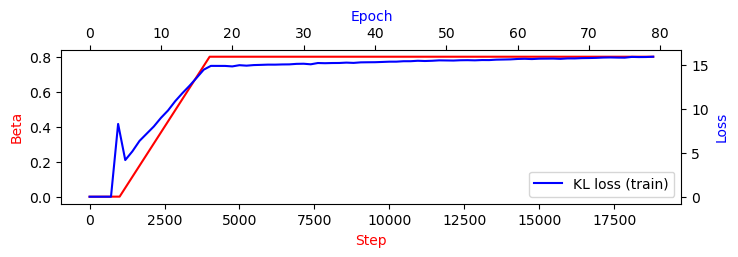

In [892]:
fig = plt.figure(figsize=(8,2))
ax1 = fig.add_subplot(111, label='1')
ax2 = fig.add_subplot(111, label='2', frame_on=False)


ax1.plot(range(step), beta_vals, color='red', label = "Beta")
ax1.set_xlabel("Step", color='red')
ax1.set_ylabel("Beta", color='red')
plt.legend()

ax2.plot(range(epochs), train_kl_losses, color='blue', label = "KL loss (train)")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel("Epoch", color='blue')
ax2.set_ylabel("Loss", color='blue')
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
plt.legend()
plt.show()

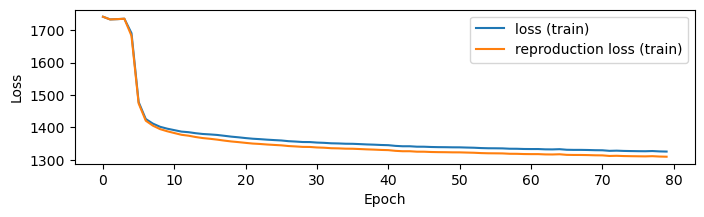

In [893]:
plt.figure(figsize=(8,2))
plt.plot(range(epochs), train_losses, label = "loss (train)")
plt.plot(range(epochs), train_r_losses, label = "reproduction loss (train)")
#plt.plot(range(epochs), validation_loss, label = 'validation_loss')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

# plt.figure(figsize=(8,2))
# plt.plot(range(epochs), train_kl_losses, label = "KL loss (train)")
# plt.legend()
# plt.ylabel("Loss")
# plt.xlabel("Epoch")
# plt.show()

# Evaluate the model

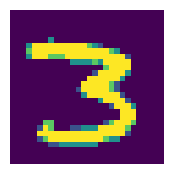

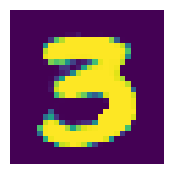

In [929]:
model.eval()
examples = enumerate(test_loader)
with torch.no_grad():
    batch, (x, labels) = next(examples)
    x = x.view(batch_size_test, dim_input)
    x = x.to(DEVICE)
    x_hat, _, _ = model(x)
    #z, _ = model.Encoder(x)
    #x_hat2 = model.Decoder(z)

def show_image_in_batch(images, idx):
    images = images.view(images.shape[0], 28, 28)
    fig = plt.figure(figsize=(2,2))
    plt.imshow(images[idx].cpu().numpy())
    plt.axis('off')
    plt.show()

show_image_in_batch(x, idx=0)
show_image_in_batch(x_hat, idx=0)
#show_image_in_batch(x_hat2, idx=0)


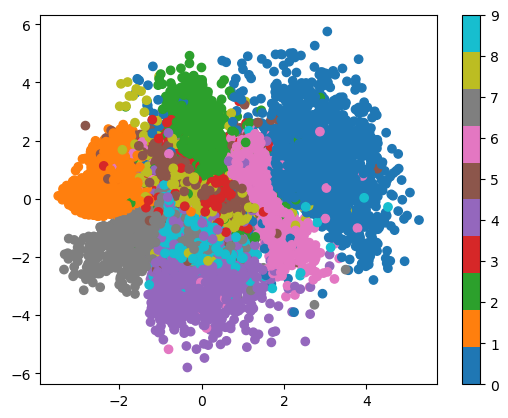

In [895]:
def plot_latent_space2d(model, data, dims=[0,1], n_batches=100):
    with torch.no_grad():
        for i, (x, labels) in enumerate(data):
            batch_size = x.size(0)
            x = x.view(batch_size, dim_input)
            z = model.get_latents(x.to(DEVICE))
            z = z.cpu().detach().numpy()
            plt.scatter(z[:, dims[0]], z[:, dims[1]], c = labels, cmap = 'tab10')

            if i+1 >= n_batches:
                plt.colorbar()
                break

plot_latent_space2d(model, train_loader, n_batches=100)

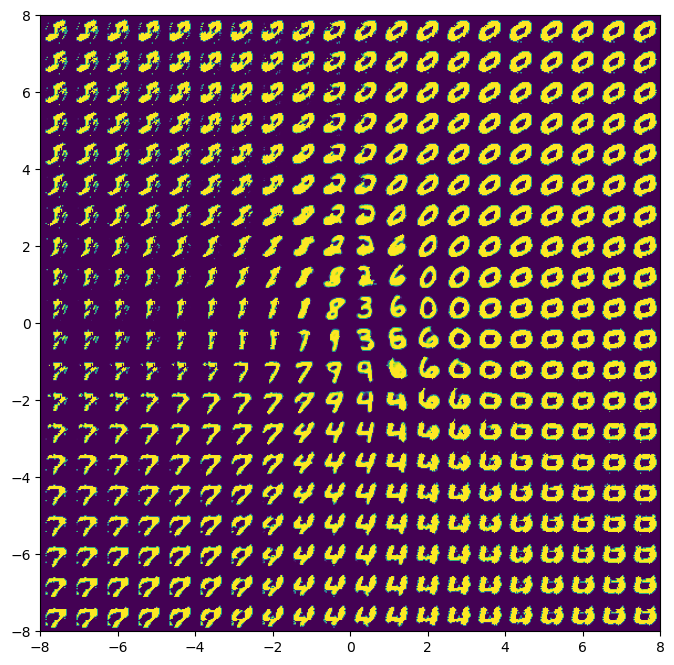

In [896]:
def plot_reconstructed(model, ax0=(-5, 5), ax1=(-5,5), n=12, figsize=(8,8)):
    """ Sample uniformly from the latent space, and see how the decoder reconstructs inputs from arbitrary latents. """
    images = np.zeros((n*28, n*28))

    for i, y in enumerate(np.linspace(*ax0, n)):
        for j, x in enumerate(np.linspace(*ax1, n)):
            z = torch.Tensor([[x, y]]).to(DEVICE)
            x_hat = model.Decoder(z)
            x_hat = x_hat.view(x_hat.shape[0], 28, 28)
            x_hat = x_hat.cpu().detach().numpy()
            images[ (n-1-i)*28 : (n-1-i+1)*28, j*28 : (j+1)*28] = x_hat
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.imshow(images, extent=[*ax0, *ax1])
    ax.set_aspect('auto')
    plt.show()
plot_reconstructed(model, ax0=(-8,8), ax1=(-8,8), n=20)